# MSCI 434 Term Project

## 1. Import Packages and Licenses

In [3]:

import gurobipy as gp
from gurobipy import GRB as GRB

In [4]:
e = gp.Env(empty = True)
#e.setParam('HOSTNAME', 'v1040-wn-rt-b-69-164.campus-dynamic.uwaterloo.ca')
#e.setParam('HOSTID', 'dc5a3818')
#e.setParam('USERNAME', 'sarankan')
#e.setParam('KEY', 'GBQGVJSF')
#e.setParam('LICENSEID', 2397655)
e.start()

model = gp.Model(env = e)

Restricted license - for non-production use only - expires 2024-10-28


# 2. Setting up Gurobi 

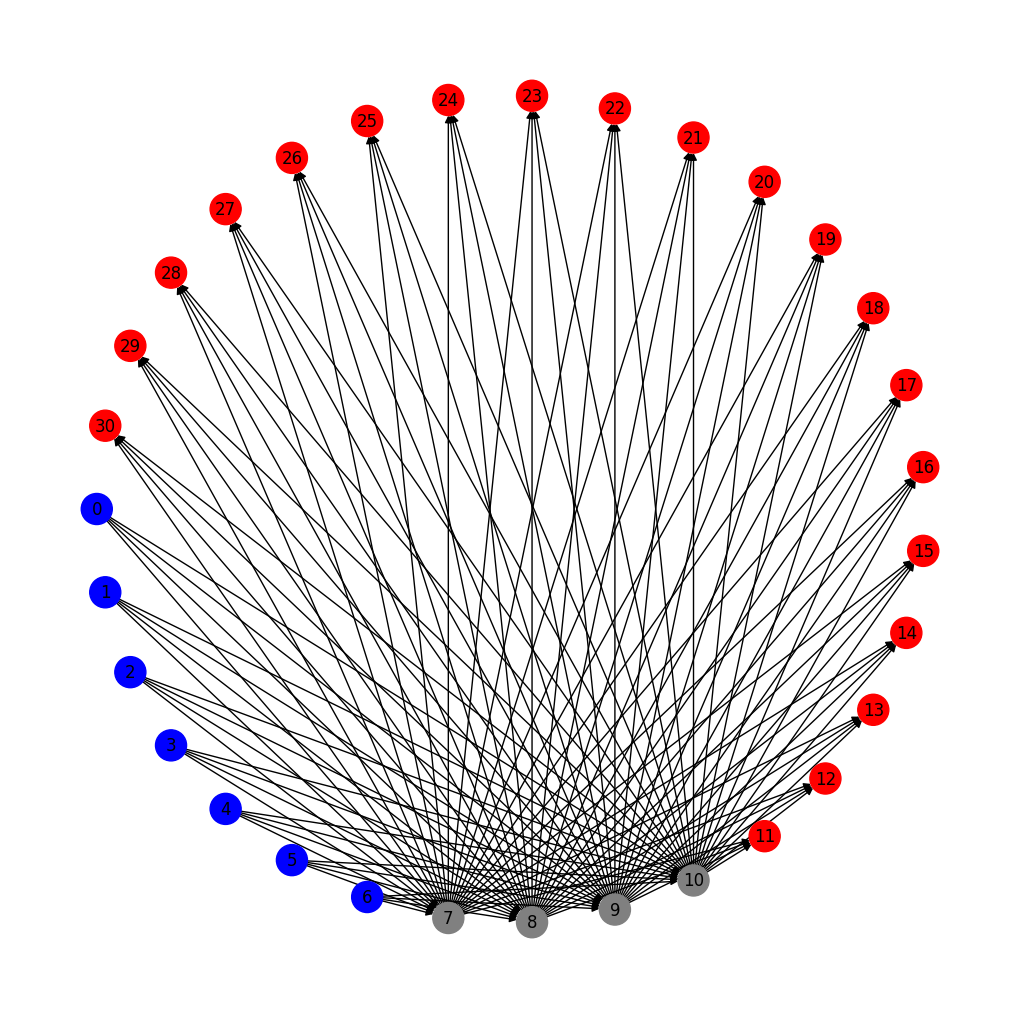

In [10]:
from itertools import combinations, groupby
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

#Suppliers send product to the distribution centres
supplier = 7
#The distribution centres receive the HelloFresh product and package the product
dc = 4
#The customers within receive the packaged goods
customer = 20

# original version from https://stackoverflow.com/a/61961881
def create_graph(suppliers, dcs, customers):
    node_colors = []
    G = nx.DiGraph()
    #suppliers_to_dcs = []
    location_edges = []

    supplierNodes = np.arange(suppliers).tolist()
    G.add_nodes_from(supplierNodes)

    dcNodes = np.arange(suppliers, suppliers + dcs).tolist()
    G.add_nodes_from(dcNodes)

    for i in supplierNodes:
      for j in dcNodes:
        location_edges.append((i,j))

    customerNodes = np.arange(suppliers + dcs, suppliers + dcs + customers).tolist()
    G.add_nodes_from(customerNodes)

    for i in dcNodes:
      for j in customerNodes:
        location_edges.append((i,j))

    G.add_edges_from(location_edges)

    return G


node_colors = []
for i in range(supplier):
  node_colors.append('blue')

for i in range(dc):
  node_colors.append('grey')

for i in range(customer):
  node_colors.append('red')

G = create_graph(supplier, dc, customer)
# visualizing the graph
plt.figure(figsize=(10,10))
nx.draw_shell(G, node_color=node_colors,
        with_labels=True,
        node_size=500)

Set up costs of transportation along arcs, and supply/demand at nodes

In [16]:
from random import randint
import numpy as np

# extract nodes and arcs from the constructed graph
nodes = list(G.nodes) # [i for i in range(1, 20)]
arcs = list(G.edges) # [(1, 2), (1, 3)] # list(G.edges)
arc_costs_dict = {}

K = 1
source_nodes = nodes[:supplier]
sink_nodes = nodes[supplier + dc::]
arc_costs = np.random.uniform(low=0, high=1, size=(len(arcs), K))  # unit flow costs [arc, k]
throughputs = np.zeros((len(nodes), K))  # supply requirements [node]

supplies = np.random.randint(low=100, high=300, size=(supplier))

for i in range(len(arcs)):
  arc_costs_dict[arcs[i]] = arc_costs[i]

units = []
for idx in range(customer - 1):
    # https://stackoverflow.com/questions/53494200/how-to-split-a-number-into-12-random-in-python-and-all-random-number-sum-to-be-e
    units.append(randint(1,sum(supplies)- sum(units)- customer + idx))
units.append(sum(supplies)-sum(units))

throughputs[source_nodes, range(K)] = supplies

for i in range(len(units)):
  throughputs[i + supplier + dc] = -units[i]

# printing some problem information
print("Source nodes:")
for i in range(supplier):
  print(f'Source node {i} has {throughputs[i]} units of supply')

print("Demand nodes:")
for i in range(supplier + dc, supplier + dc + customer):
  print(f'Demand node {i} has {-throughputs[i]} units of demand')
print()  # to clear last result

Source nodes:
Source node 0 has [161.] units of supply
Source node 1 has [128.] units of supply
Source node 2 has [164.] units of supply
Source node 3 has [213.] units of supply
Source node 4 has [234.] units of supply
Source node 5 has [244.] units of supply
Source node 6 has [232.] units of supply
Demand nodes:
Demand node 11 has [889.] units of demand
Demand node 12 has [375.] units of demand
Demand node 13 has [9.] units of demand
Demand node 14 has [64.] units of demand
Demand node 15 has [6.] units of demand
Demand node 16 has [8.] units of demand
Demand node 17 has [1.] units of demand
Demand node 18 has [8.] units of demand
Demand node 19 has [1.] units of demand
Demand node 20 has [2.] units of demand
Demand node 21 has [3.] units of demand
Demand node 22 has [1.] units of demand
Demand node 23 has [1.] units of demand
Demand node 24 has [1.] units of demand
Demand node 25 has [1.] units of demand
Demand node 26 has [1.] units of demand
Demand node 27 has [1.] units of demand


Add constraints

In [22]:
# TODO
# Indices: quality index q, temperature index k, time index t
# Sets: set of all quality levels Q
# Parameters: min acceptable quality level at facility i (for dcs and customers), 
# model implementation
model = gp.Model("HelloFresh Meal Kit Delivery Supply Chain Optimization")

meal_kits = model.addVars(arcs, vtype=GRB.INTEGER, name='meal_kits')

max_capacity = 300

# supply
for j in range(supplier):
  total = 0
  for i in range(supplier, supplier + dc):
    total += meal_kits[j, i]
  model.addConstr(total == throughputs[j])

# demand
for j in range(supplier + dc, supplier + dc + customer):
  total = 0
  for i in range(supplier, supplier + dc):
    total += meal_kits[i,j]
  model.addConstr(total == -throughputs[j])

# intermediary nodes
for i in range(supplier, supplier + dc):
  incoming = 0
  outgoing = 0
  for supply in range(supplier):
    incoming += meal_kits[supply, i]
  
  for d in range(supplier + dc, supplier + dc + customer):
    outgoing += meal_kits[i, d]
  model.addConstr(incoming == outgoing)


# capacity constraints
for (i,j) in arcs:
  model.addConstr(meal_kits[i,j] <= max_capacity)
  model.addConstr(meal_kits[i,j] >= 0)

# set objective
model.setObjective(
    sum([(meal_kits[i,j]*arc_costs_dict[(i,j)]) for (i,j) in arcs]),
    sense=GRB.MINIMIZE
)


# optimize
model.optimize()

for i in meal_kits:
  print(f'Arc {i[0]} to {i[1]}: {meal_kits[i]}')


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 247 rows, 108 columns and 432 nonzeros
Model fingerprint: 0x6717a03c
Variable types: 0 continuous, 108 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+02]
Found heuristic solution: objective 1763.2500055
Presolve removed 216 rows and 0 columns
Presolve time: 0.00s
Presolved: 31 rows, 108 columns, 216 nonzeros
Variable types: 0 continuous, 108 integer (40 binary)

Root relaxation: objective 1.080102e+03, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1080.1021293 1080.10213  0.00%     -    0s

Explored 1

/var/folders/b5/30vg695j1lb1xbk9tgx40n1w0000gn/T/ipykernel_1588/3209842548.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model.addConstr(total == throughputs[j])
/var/folders/b5/30vg695j1lb1xbk9tgx40n1w0000gn/T/ipykernel_1588/3209842548.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model.addConstr(total == -throughputs[j])
/var/folders/b5/30vg695j1lb1xbk9tgx40n1w0000gn/T/ipykernel_1588/3209842548.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  su